In [1]:
from optimization import *
import optimization
import sys
import importlib
import rotation
importlib.reload(optimization)
sys.path.append("../python")
import parseCouplings
sys.path.append("../Netket")

In [ ]:
# Todo: replace this function with actual file reading
def readHamiltonian_params(file, idx, N):
    Jijalphabeta = np.random.rand(3, 3, N, N)
    h = np.random.rand(3, N)

    # Delete 90% of the elements randomly in Jijalphabeta
    mask_J = np.random.rand(3, 3, N, N) < 0.1
    Jijalphabeta = Jijalphabeta * mask_J

    # Delete 90% of the elements randomly in h
    mask_h = np.random.rand(3, N) < 0.1
    h = h * mask_h

    return Jijalphabeta, h


def generate_tfim_params(N, J=1.0, h=1.0):
    """
    Generates Jij and h arrays for the transverse field Ising model (TFIM):
    H = -J sum_{<i,j>} sigma^z_i sigma^z_j - h sum_i sigma^x_i

    Args:
        N (int): Number of spins (1D chain with periodic boundary).
        J (float): Coupling strength.
        h (float): Transverse field strength.

    Returns:
        Jij (np.ndarray): shape (3, 3, N, N), only Jij[2,2,i,j] nonzero for nearest neighbors.
        h (np.ndarray): shape (3, N), only h[0,i] nonzero (x direction).
    """
    Jij = np.zeros((3, 3, N, N))
    for i in range(N):
        j = (i + 1) % N  # periodic boundary
        Jij[2, 2, i, j] = -J
        Jij[2, 2, j, i] = -J  # symmetric

    h_arr = np.zeros((3, N))
    h_arr[0, :] = -h  # transverse field in x direction

    return Jij, h_arr

def TFI2D(g, J=1.0, h=1.0):
    hi = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
    H = -J*sum(nk.operator.spin.sigmaz(hi, i) * nk.operator.spin.sigmaz(hi, j) for( i, j) in g.edges()) 
    H += -h*sum(nk.operator.spin.sigmax(hi,i) for i in g.nodes())

    return H
g = nk.graph.Hypercube(length=4, n_dim=2, pbc=True)

def construct_hamiltonian_bonds_heisenberg(Jijalphabeta, h, bonds):
    # Jijalphabeta = np.array([np.eye(3)*np.max(Jijalphabeta[bond,:,:]) for bond in range(len(bonds))])
    Jijalphabeta = np.array([np.eye(3) for bond in range(len(bonds))])
    return construct_hamiltonian_bonds(Jijalphabeta, h, bonds)


In [3]:
Jij,h,bonds = parseCouplings.parseCouplings("../python/couplings69.csv")

In [4]:
# Jij, h = readHamiltonian_params("hamiltonian_params.txt", 0, 5)
import os
os.chdir("../python")
Jij,h,bonds = parseCouplings.parseCouplings()
# H_ran = construct_hamiltonian_bonds_heisenberg(Jij[10], 0*h[10],  bonds[10])
H_ran = construct_hamiltonian_bonds_rotated(Jij[10], 0*h[10],  bonds[10], 0.1,0.2,0.3)
epsilon = 0.8
H2 = TFI2D(g, 1, 0.5)
H = H_ran
# H = epsilon*H_ran + H2
exact_ground_energy,exact_ground_state = nk.exact.lanczos_ed(H, k = 1, compute_eigenvectors = True)
print("Exact ground state energy:", exact_ground_energy)

Exact ground state energy: [-54.03992906]


In [ ]:
importlib.reload(optimization)

<module 'optimization' from '/net/storage/niggeni/Documents/Projects/DataMiningRBMs/python/../Netket/optimization.py'>

In [40]:
Jij_hash = hash(Jij.tobytes())
h_hash = hash(h.tobytes())

params = generate_params(
    alpha=30,
    seed=1234,
    learning_rate=3e-3,
    n_iter=100,
    show_progress=True,
    out="data/rbm_optimization_test_symm",
    symmetries = g.automorphisms(),
    H_hash = hash(H),
    diag_shift=0.5,
    # Jij_hash=Jij_hash,
    # h_hash=h_hash,
)

# out = optimize_rbm(H, params)


In [14]:
params2 = generate_params(
    alpha=1,
    seed=1234,
    learning_rate=3e-2,
    n_iter=10,
    show_progress=True,
    out="data/rbm_optimization_test_2",
    # symmetries = g.automorphisms(),
    epsilon = epsilon,
    diag_shift=8e-3,
    # Jij_hash=Jij_hash,
    # h_hash=h_hash,
)

out2 = optimize_rbm(H, params2)

  0%|          | 0/10 [00:00<?, ?it/s]

In [41]:
out2.expect(H)

-5.296e+01+5.898e-17j [σ²=9.6e+00]

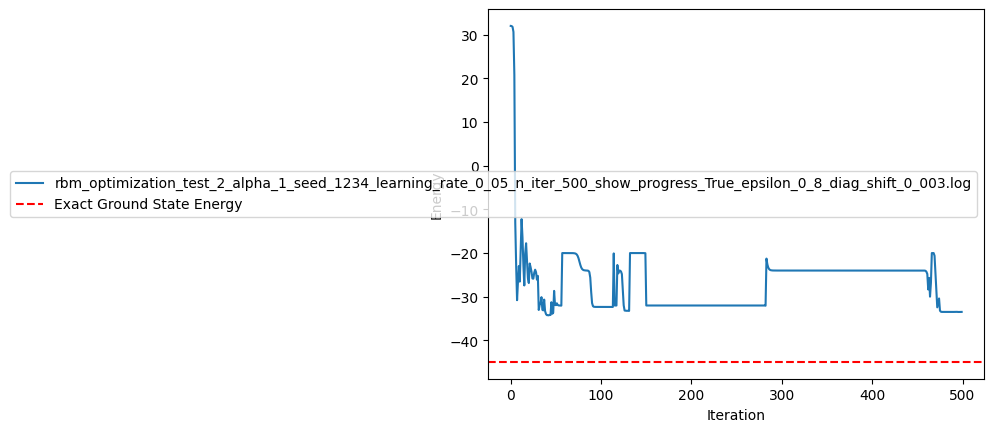

In [44]:
import json
import os
import matplotlib.pyplot as plt
log_files = [os.path.join("data", f) for f in os.listdir("data") if f.endswith(".log")]

fig, ax = plt.subplots()

# Extract the common prefix from all log file names

for log_file in log_files:
    with open(log_file) as f:
        data_rbm = json.load(f)
    iters = data_rbm["Energy"]["iters"]
    energy = data_rbm["Energy"]["Mean"]["real"]
    # Use the substring that differs from the common prefix as the label
    label = os.path.basename(log_file)
    ax.plot(iters, energy, label=label)

ax.set_xlabel("Iteration")
ax.set_ylabel("Energy")
plt.axhline(y=exact_ground_energy, color='r', linestyle='--', label='Exact Ground State Energy')
ax.legend()
plt.show()


In [ ]:
import analysis
analysis.read_h5_attributes(params2["out"] + ".h5")

{'alpha': np.int64(1),
 'epsilon': np.float64(0.1),
 'learning_rate': np.float64(0.003),
 'n_iter': np.int64(400),
 'out': 'data/rbm_optimization_test_2_alpha_1_seed_1234_learning_rate_0_003_n_iter_400_show_progress_True_symmetric_False_epsilon_0_1',
 'seed': np.int64(1234),
 'show_progress': np.True_,
 'symmetric': np.False_}

In [ ]:
write_output(H, out2, params2)

Could not read log file data/rbm_optimization_test_2_alpha_48_seed_1234_learning_rate_0_003_n_iter_400_show_progress_True_epsilon_0_8_diag_shift_0_01.log: [Errno 2] No such file or directory: 'data/rbm_optimization_test_2_alpha_48_seed_1234_learning_rate_0_003_n_iter_400_show_progress_True_epsilon_0_8_diag_shift_0_01.log'
Flipping the sign of the ground state wavefunction to ensure positive overlap.


In [40]:
params = generate_params(
    alpha=1,
    seed=1234,
    learning_rate=8e-3,
    n_iter=300,
    show_progress=True,
    rot_alpha= 0,
    rot_beta=0.5*np.pi,
    rot_gamma=0.6241423,
    out=f"../data/data_rotated/rbm_optimization",
)
params["out"]

'../data/data_rotated/rbm_optimization_alpha_1_seed_1234_learning_rate_0_008_n_iter_300_show_progress_True_rot_alpha_0_rot_beta_1_5707963267948966_rot_gamma_0_6241423'

In [43]:
Jij,h,bonds = parseCouplings.parseCouplings("../python/couplings69.csv")
angle_range = np.linspace(0, 0.5*np.pi, 2)

for alpha in angle_range:
    for beta in angle_range:
        for gamma in angle_range:
            H = construct_hamiltonian_bonds_rotated(Jij[50], h[50],  bonds[50], alpha, beta, gamma)
            exact_ground_energy,exact_ground_state = nk.exact.lanczos_ed(H, k = 1, compute_eigenvectors = True)

            print(f"Angles: ({alpha:.2f}, {beta:.2f}, {gamma:.2f}), Hamiltonian: Exact ground state energy: {exact_ground_energy[0]}")

            params = generate_params(
                alpha=1,
                seed=1234,
                learning_rate=8e-3,
                n_iter=400,
                show_progress=True,
                rot_alpha=alpha,
                rot_beta=beta,
                rot_gamma=gamma,
                out=f"../data/data_rotated/rbm_optimization",
            )
            out = optimize_rbm(H, params)
            
            write_output(H, out, params)

Angles: (0.00, 0.00, 0.00), Hamiltonian: Exact ground state energy: -54.26621412990654


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (0.00, 0.00, 1.57), Hamiltonian: Exact ground state energy: -54.266214129906736


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (0.00, 1.57, 0.00), Hamiltonian: Exact ground state energy: -54.266214129906736


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (0.00, 1.57, 1.57), Hamiltonian: Exact ground state energy: -54.266214129906594


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (1.57, 0.00, 0.00), Hamiltonian: Exact ground state energy: -54.266214129906764


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (1.57, 0.00, 1.57), Hamiltonian: Exact ground state energy: -54.26621412990656


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (1.57, 1.57, 0.00), Hamiltonian: Exact ground state energy: -54.266214129906736


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (1.57, 1.57, 1.57), Hamiltonian: Exact ground state energy: -54.266214129906835


  0%|          | 0/400 [00:00<?, ?it/s]

In [5]:
import os

# h5_files = [os.path.join("data_rand", f) for f in os.listdir('data_rand') if f.endswith('.h5')]
h5_files = [os.path.join("../data/data_rotated", f) for f in os.listdir('../data/data_rotated') if f.endswith('.h5')]
print(h5_files)

['../data/data_rotated/rbm_optimization_alpha_1_seed_1234_learning_rate_0_008_n_iter_400_show_progress_False_rot_alpha_0_3693876085377084_rot_beta_0_764288275501484_rot_gamma_1_531411503936541.h5', '../data/data_rotated/rbm_optimization_alpha_1_seed_1234_learning_rate_0_008_n_iter_400_show_progress_False_rot_alpha_0_44459293368815256_rot_beta_0_008973149430378965_rot_gamma_0_4593948646110098.h5', '../data/data_rotated/rbm_optimization_alpha_1_seed_1234_learning_rate_0_008_n_iter_400_show_progress_False_rot_alpha_0_36456339480663824_rot_beta_1_3272476633202974_rot_gamma_0_976046924083371.h5', '../data/data_rotated/rbm_optimization_alpha_1_seed_1234_learning_rate_0_008_n_iter_400_show_progress_False_rot_alpha_1_025806591604705_rot_beta_0_6636879804448029_rot_gamma_0_40389680946782824.h5', '../data/data_rotated/rbm_optimization_alpha_1_seed_1234_learning_rate_0_008_n_iter_400_show_progress_False_rot_alpha_0_8636729976004734_rot_beta_0_894598848776103_rot_gamma_0_1542775870366362.h5', '../

In [6]:
from analysis import *
load_outputs_to_dataframe(h5_files)

,psi,psi_0,Delta_E,infidelity
0,"[(-0.0009071705+0.00031600223j), (0.0003175422...",[(-0.0011822779292414843+0.0006514321570310087...,0.103743,0.990176
1,"[(-1.0200166e-05+9.107927e-06j), (8.151106e-06...",[(-1.808286313931901e-07+3.2005616770418713e-0...,0.123186,0.999948
2,"[(0.001995487-0.023808798j), (-0.005822409+0.0...","[(0.007111324009398755-0.023676767848941994j),...",0.000733,0.002392
3,"[(0.0041645826-0.006317043j), (-0.00053992827+...",[(-0.007333034090437174-2.849224019744056e-05j...,0.000531,0.001442
4,"[(0.007687317+0.0068763364j), (-0.007626226+0....","[(0.010362418637859106+0.003490020874530769j),...",0.001576,0.004966
5,"[(-0.020315237+0.02570005j), (0.013498547-0.01...","[(0.022037945842076318-0.029903528534419344j),...",0.067546,0.697001
6,"[(-2.9715607e-06-1.18197946e-07j), (2.1757134e...",[(-0.00047126691192422637+0.000426507344858401...,0.122952,0.999761
7,"[(-5.344648e-07-2.282598e-05j), (1.6885562e-05...",[(-1.2387411686823587e-06+1.0086708220736559e-...,0.119888,0.998356
8,"[(0.007199597+0.0066867205j), (-0.00829119+0.0...",[(0.008502770886371745+0.0039914278156320095j)...,0.000494,0.001289
9,"[(0.011822619+0.0041554035j), (-0.00958271-0.0...","[(0.0018785822392949068+0.01273557525003682j),...",0.003552,0.025589


In [22]:
import optuna
def objective(trial):
    # Suggest values for alpha, beta, gamma in [0, 0.5*np.pi]
    alpha = trial.suggest_float('alpha', 0, 0.5*np.pi)
    beta = trial.suggest_float('beta', 0, 0.5*np.pi)
    gamma = trial.suggest_float('gamma', 0, 0.5*np.pi)
    
    # Construct Hamiltonian with suggested angles
    H = construct_hamiltonian_bonds_rotated(Jij[50], h[50], bonds[50], alpha, beta, gamma)
    
    params = generate_params(
        alpha=1,
        seed=1234,
        learning_rate=8e-3,
        n_iter=400,
        show_progress=False,
        rot_alpha=alpha,
        rot_beta=beta,
        rot_gamma=gamma,
        out=f"../data/data_rotated/rbm_optimization",
    )
    out = optimize_rbm(H, params)
    write_output(H, out, params)
    en = out.expect(H).real().mean
    return en

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Best angles found:")
print("alpha =", study.best_params['alpha'])
print("beta =", study.best_params['beta'])
print("gamma =", study.best_params['gamma'])
print("Minimum ground state energy =", study.best_value)

[I 2025-09-29 18:58:44,397] A new study created in memory with name: no-name-09990567-cc5e-402a-99bb-d46990878aac
[I 2025-09-29 18:59:41,094] Trial 0 finished with value: -47.61823726144692 and parameters: {'alpha': 0.992825121449861, 'beta': 0.28184134120550663, 'gamma': 1.1704005709525558}. Best is trial 0 with value: -47.61823726144692.
[I 2025-09-29 19:00:54,298] Trial 1 finished with value: -47.58141012177944 and parameters: {'alpha': 0.44459293368815256, 'beta': 0.008973149430378965, 'gamma': 0.4593948646110098}. Best is trial 0 with value: -47.61823726144692.
[I 2025-09-29 19:01:58,033] Trial 2 finished with value: -47.766371041298314 and parameters: {'alpha': 0.1148616042331309, 'beta': 0.216217833955141, 'gamma': 1.4334885673588642}. Best is trial 2 with value: -47.766371041298314.
[I 2025-09-29 19:03:12,716] Trial 3 finished with value: -54.23380740311619 and parameters: {'alpha': 0.15770960222919114, 'beta': 1.4469284030393488, 'gamma': 0.7115125625756978}. Best is trial 3 w

Best angles found:
alpha = 0.18610694312202125
beta = 1.4130236875883821
gamma = 1.4413482562269746
Minimum ground state energy = -54.24264712903329


In [9]:
# os.chdir("Netket")
import importlib
import analysis
importlib.reload(analysis)

<module 'analysis' from '/net/storage/niggeni/Documents/Projects/DataMiningRBMs/python/../Netket/analysis.py'>

In [29]:
hypotheses = {
    "std_phase" : std_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
}
df = load_outputs_to_dataframe(h5_files)
df = attach_hypotheses_fields(df, hypotheses)
df["rot_alpha"] = np.array([analysis.read_h5_attributes(f)["rot_alpha"] for f in h5_files])
df["rot_beta"] = np.array([analysis.read_h5_attributes(f)["rot_beta"] for f in h5_files])
df["rot_gamma"] = np.array([analysis.read_h5_attributes(f)["rot_gamma"] for f in h5_files])

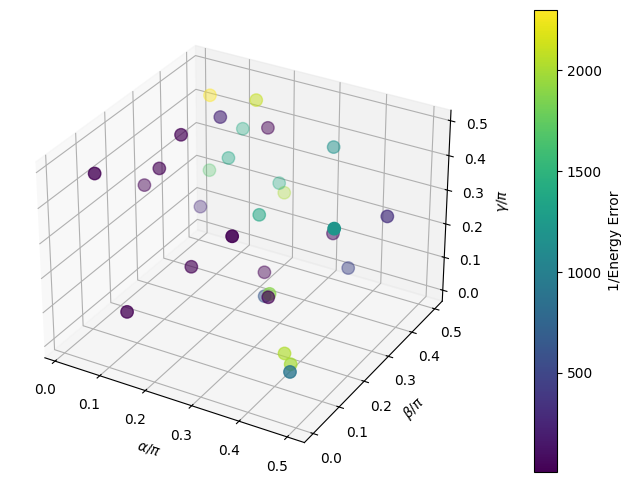

In [11]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Extract rotation angles and energy error
energy_error = 1/df["Delta_E"]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df["rot_alpha"]/np.pi, df["rot_beta"]/np.pi, df["rot_gamma"]/np.pi, c=energy_error, cmap='viridis', s=80)
ax.set_xlabel(r"$\alpha/\pi$")
ax.set_ylabel(r"$\beta/\pi$")
ax.set_zlabel(r"$\gamma/\pi$")
plt.colorbar(sc, label="1/Energy Error", pad=0.1)
plt.show()

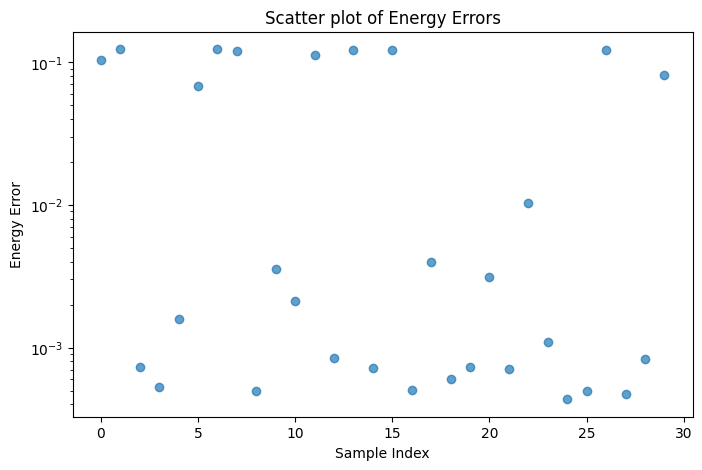

In [24]:
import matplotlib.pyplot as plt

# Assuming df["Delta_E"] contains arrays, extract the first element for each entry
energies = df["Delta_E"]

plt.figure(figsize=(8, 5))
plt.scatter(range(len(energies)), energies, alpha=0.7)
plt.xlabel("Sample Index")
plt.ylabel("Energy Error")
plt.yscale("log")
plt.title("Scatter plot of Energy Errors")
plt.show()

Jij[50] before rotation:
 [[-0.41859285  0.63976083 -1.5100352 ]
 [ 0.83865364  0.86525379  0.50709675]
 [-0.44708352  0.8977601   0.16044521]]
h[50] before rotation:
 [-0.17039252  0.10899523  0.70310945]

Optimal rotation angles: alpha=0.18610694312202125, beta=1.4130236875883821, gamma=1.4413482562269746
Jij[50] after optimal rotation:
 [[ 0.34427449 -0.74597492  0.84528365]
 [-1.13197848  0.40423823  0.26983036]
 [ 0.92521     1.34994864 -0.14140657]]
h[50] after optimal rotation:
 [0.10999631 0.66691242 0.28000911]


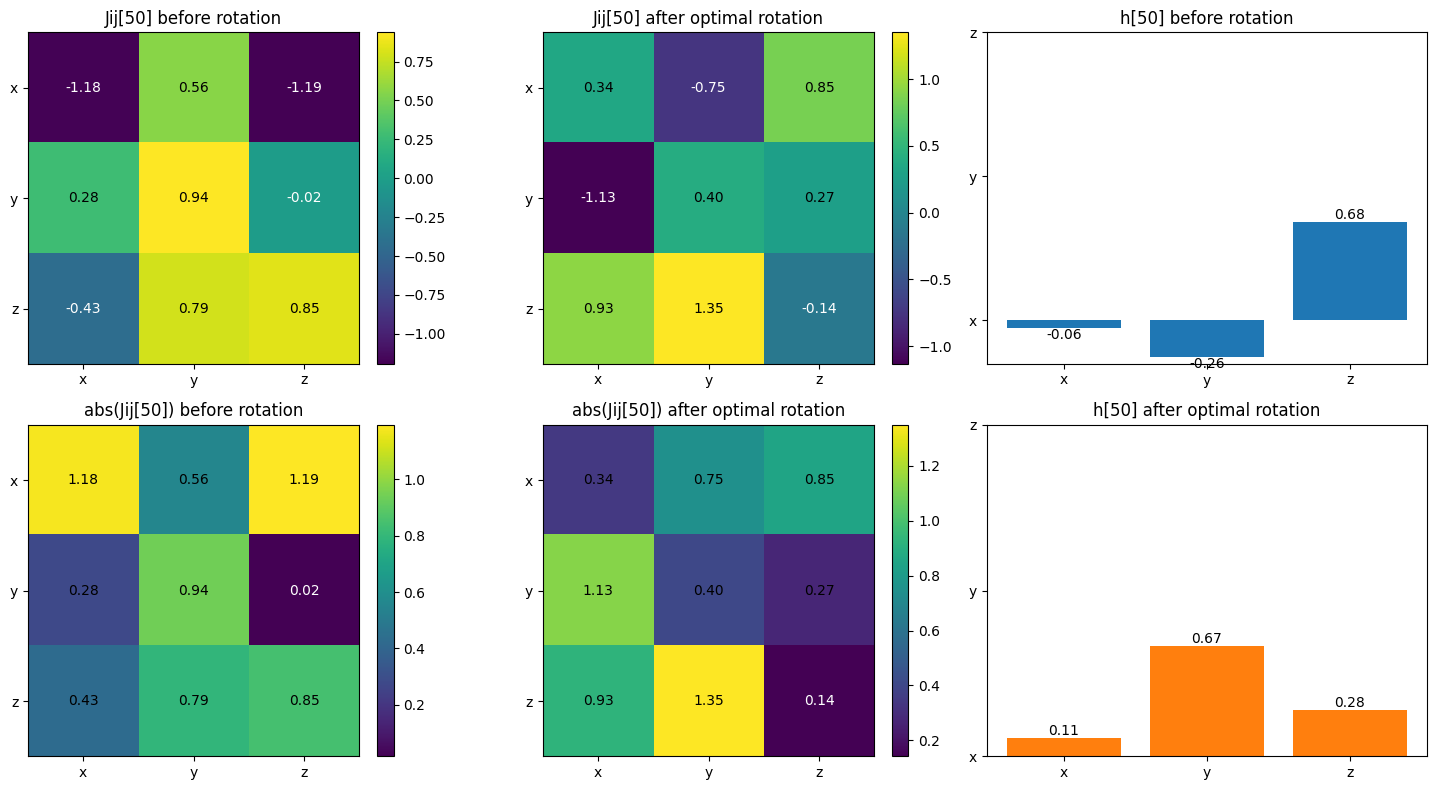

In [28]:
# Show Jij[50] and h[50] before rotation

J_check,h_check = Jij[50][1,:,:], h[50][1,:]

# J_check = np.array([[1, 2, 3],
                    # [4, 0, 0],
                    # [5, 0, 0]])
print("Jij[50] before rotation:\n", J_check)
print("h[50] before rotation:\n", h_check)

# Find the index of the minimum Delta_E
min_idx = df["Delta_E"].idxmin()
max_idx = df["Delta_E"].idxmax()

# Get optimal rotation angles
alpha_opt = df["rot_alpha"][min_idx]
beta_opt = df["rot_beta"][min_idx]
gamma_opt = df["rot_gamma"][min_idx]

# Apply rotation
R_opt = rotation.rotation_matrix_rpy(alpha_opt, beta_opt, gamma_opt)
Jij_rotated = R_opt @ J_check @ R_opt.T
h_rotated = R_opt @ h_check


R_worst = rotation.rotation_matrix_rpy(df["rot_alpha"][max_idx], df["rot_beta"][max_idx], df["rot_gamma"][max_idx])
Jij_worst = R_worst @ J_check @ R_worst.T
h_worst = R_worst @ h_check
J_check = Jij_worst
h_check = h_worst
print(f"\nOptimal rotation angles: alpha={alpha_opt}, beta={beta_opt}, gamma={gamma_opt}")
print("Jij[50] after optimal rotation:\n", Jij_rotated)
print("h[50] after optimal rotation:\n", h_rotated)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Jij[50] before rotation
im0 = axes[0, 0].imshow(J_check, cmap='viridis')
axes[0, 0].set_title("Jij[50] before rotation")
plt.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)

# abs(Jij[50]) before rotation
im0_abs = axes[1, 0].imshow(np.abs(J_check), cmap='viridis')
axes[1, 0].set_title("abs(Jij[50]) before rotation")
plt.colorbar(im0_abs, ax=axes[1, 0], fraction=0.046, pad=0.04)

# Jij[50] after optimal rotation
im1 = axes[0, 1].imshow(Jij_rotated, cmap='viridis')
axes[0, 1].set_title("Jij[50] after optimal rotation")
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)

# abs(Jij[50]) after optimal rotation
im1_abs = axes[1, 1].imshow(np.abs(Jij_rotated), cmap='viridis')
axes[1, 1].set_title("abs(Jij[50]) after optimal rotation")
plt.colorbar(im1_abs, ax=axes[1, 1], fraction=0.046, pad=0.04)

# h[50] before rotation
axes[0, 2].bar(range(len(h_check)), h_check, color='C0')
axes[0, 2].set_title("h[50] before rotation")

# h[50] after optimal rotation
axes[1, 2].bar(range(len(h_rotated)), h_rotated, color='C1')
axes[1, 2].set_title("h[50] after optimal rotation")

# Annotate matrix entries with color based on mean
mean_J_check = np.mean(J_check)
mean_Jij_rotated = np.mean(Jij_rotated)

for (i, j), val in np.ndenumerate(J_check):
    color = 'k' if val > mean_J_check else 'w'
    axes[0, 0].text(j, i, f"{val:.2f}", ha='center', va='center', color=color, fontsize=10)
for (i, j), val in np.ndenumerate(np.abs(J_check)):
    color = 'k' if val > mean_J_check else 'w'
    axes[1, 0].text(j, i, f"{val:.2f}", ha='center', va='center', color=color, fontsize=10)
for (i, j), val in np.ndenumerate(Jij_rotated):
    color = 'k' if val > mean_Jij_rotated else 'w'
    axes[0, 1].text(j, i, f"{val:.2f}", ha='center', va='center', color=color, fontsize=10)
for (i, j), val in np.ndenumerate(np.abs(Jij_rotated)):
    color = 'k' if val > mean_Jij_rotated else 'w'
    axes[1, 1].text(j, i, f"{val:.2f}", ha='center', va='center', color=color, fontsize=10)

# Annotate bar entries with color based on mean

for idx, val in enumerate(h_check):
    va = 'bottom' if val >= 0 else 'top'
    axes[0, 2].text(idx, val, f"{val:.2f}", ha='center', va=va, fontsize=10)
for idx, val in enumerate(h_rotated):
    va = 'bottom' if val >= 0 else 'top'
    axes[1, 2].text(idx, val, f"{val:.2f}", ha='center', va=va, fontsize=10)

# for ax in axes[:,0:1].flat:
for ax in axes.flat:
    if hasattr(ax, "set_xticks"):
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(['x', 'y', 'z'])
        ax.set_yticks([0,1,2])
        ax.set_yticklabels(['x', 'y', 'z'])
    if hasattr(ax, "set_yticks") and ax.get_ylabel() == '':
        ax.set_yticks(ax.get_yticks())

axes[0,2].set_xticks([0, 1, 2])
axes[0,2].set_xticklabels(['x', 'y', 'z'])
axes[1,2].set_xticks([0, 1, 2])
axes[1,2].set_xticklabels(['x', 'y', 'z'])
plt.tight_layout()
plt.show()

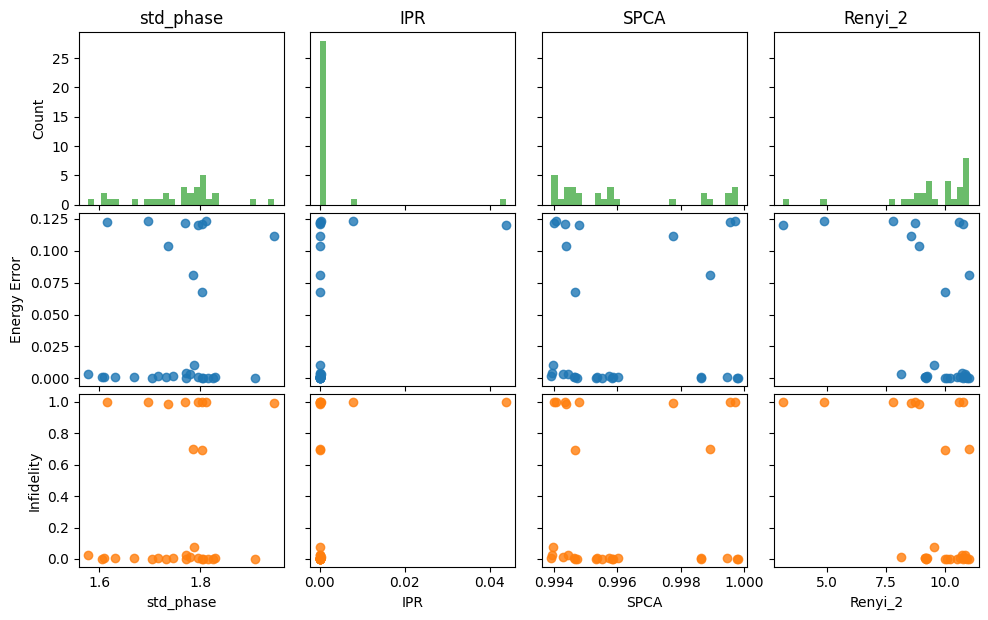

In [30]:
import matplotlib.pyplot as plt
N = len(hypotheses)
fig, axes = plt.subplots(3, N, figsize=(0.6*4*N, 0.6*10), sharey='row', sharex='col')

for idx, name in enumerate(hypotheses.keys()):
    # First row: Histogram of hypothesis values
    axes[0, idx].hist(df[name], bins=30, color="C2", alpha=0.7)
    axes[0, idx].set_title(f"{name}")
    if idx == 0:
        axes[0, 0].set_ylabel("Count")

    # Second row: Energy error vs hypothesis
    axes[1, idx].scatter(df[name], df["Delta_E"], color="C0", alpha=0.8)
    if idx == 0:
        axes[1, 0].set_ylabel("Energy Error")

    # Third row: Infidelity vs hypothesis
    infid = df.apply(lambda row: infidelity(row["psi"], row["psi_0"]), axis=1)
    axes[2, idx].scatter(df[name], infid, color="C1", alpha=0.8)
    axes[2, idx].set_xlabel(name)
    if idx == 0:
        axes[2, 0].set_ylabel("Infidelity")

plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()


In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(df["Delta_E"], infid, alpha=0.7)
plt.xlabel("Energy Error")
plt.ylabel("Infidelity")
plt.show()